In [8]:
import torchtext
import re
import numpy as np
from torchtext.data import get_tokenizer

In [9]:
def flatten(container):
    for c in container:
        for i in c:
            yield i

In [10]:
from typing import List, Callable
def get_ka_data(path_to_ka_data: str) -> List[str]:
    lines = []
    with open(path_to_ka_data) as f:
        for i in range(1_000_000):
            lines.append(f.readline())
            # N_DATA_WORDS = 1_000_000
        # data = f.read(N_DATA_WORDS * 10)
        # f.close()
        # lines = data.splitlines()
    return lines

In [11]:
# TO CHANGE DATA SOURCE CHANGE THIS
get_data: Callable[str, List[str]] = lambda: get_ka_data('./data/ka.txt')

In [12]:
# TODO: should we take functions out of notebook?
from geotok import _basic_georgian_normalize

In [13]:
# TO CHANGE TOKENIZATION METHOD CHANGE THIS
tokenizer = get_tokenizer(_basic_georgian_normalize)

In [14]:
tokenizer('20.20.2020 მაგარი თარიღია. ძვ.წ. 2020 წელიც მაგარი იყო.')

['20/20/2020',
 'მაგარი',
 'თარიღია',
 '.',
 'ძვ',
 ';',
 'წ',
 ';',
 '2020',
 'წელიც',
 'მაგარი',
 'იყო',
 '.']

In [15]:
original_data = get_data()

In [16]:
data = list(map(tokenizer, original_data))
len(data)

1000000

In [17]:
data[10:12]

[['07/12/2018',
  'აწყურის',
  'სკოლის',
  'მოსწავლე',
  'საუკეთესო',
  'ესსესთვის',
  'დააჯილდოვეს',
  '[video]'],
 ['06/12/2018',
  'შშმ',
  'მშობელი',
  'ექსკურსიას',
  'ჩამორჩა',
  ',',
  'ამის',
  'შემდეგ',
  'სკოლაში',
  'მის',
  'შვილს',
  'დაუპირისპირდნენ']]

## EDA (Exploratory Data Analysis)

In [18]:
len(data)

1000000

In [19]:
# Concatenating data from multiple sources is fine for EDA
tokens = list(flatten(data))
tokens[10:15]

[',', 'არამედ', 'საყოფაცხოვრებო', 'დანიშნულების', 'იყო']

In [20]:
len(tokens)

18742603

In [21]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [22]:
word_frequencies = Counter(tokens)

In [23]:
word_cloud = WordCloud(width=1400, height=700, font_path="./fonts/bpg_dejavu_sans.otf", collocations = False, background_color = 'white').generate_from_frequencies(word_frequencies)

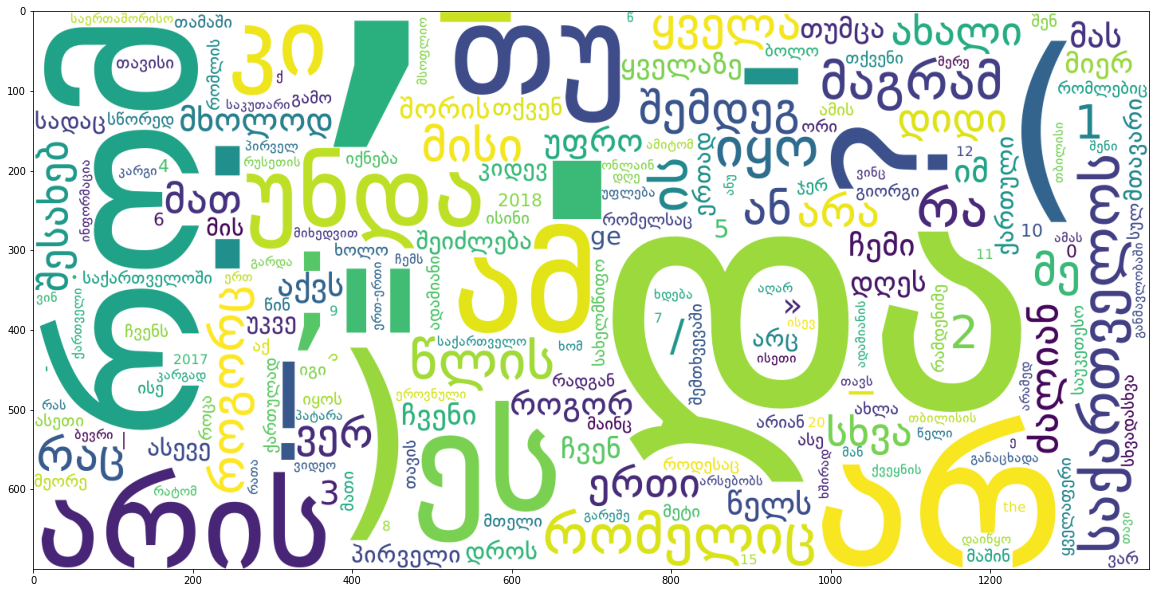

In [24]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.imshow(word_cloud);

In [27]:
from nltk import ngrams
import seaborn as sns
# sns.set(font_scale=2)

In [28]:
trigrams = Counter(ngrams(tokens, 3)).most_common(10)

In [29]:
trigram_data = [" ".join(trigram) for trigram, _ in trigrams]
trigram_freq = [freq for _, freq in trigrams]

In [32]:
sns.set(font_scale=2)

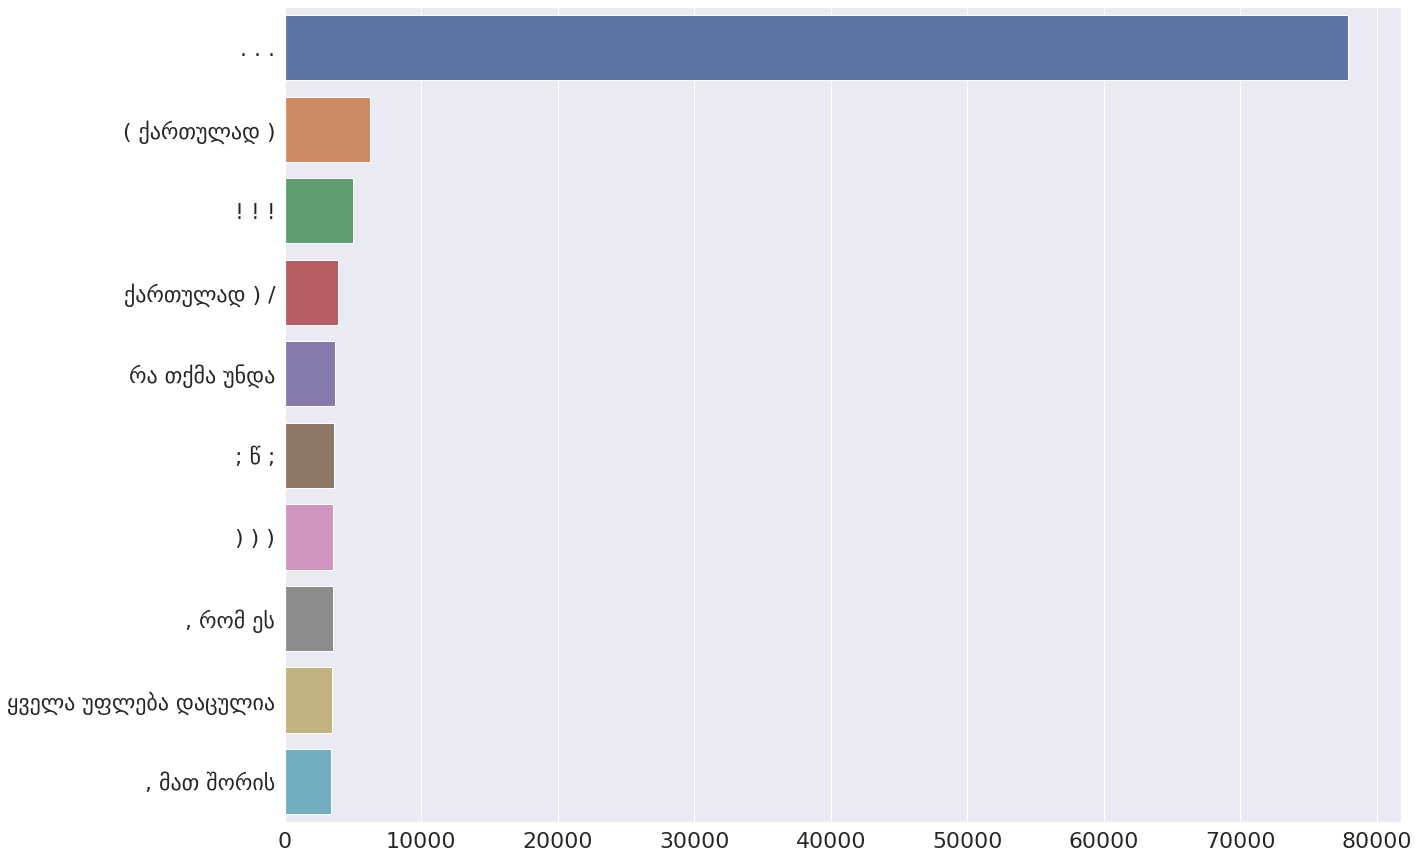

In [33]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.barplot(x=trigram_freq, y=trigram_data)
plt.show()

## Word Embeddings

In [86]:
# Take in tokens, return sentences
def basic_sentence_splitter(tokens: List[str]) -> List[List[str]]:
    sentences = []
    cur = []
    for tok in tokens:
        cur.append(tok)
        if tok in ['.', '!', '?']:
            sentences.append(cur)
            cur = []
    return sentences

In [87]:
# Take in tokens, return sentences
def sentence_splitter_bigger_than_one(tokens: List[str]) -> List[List[str]]:
    sentences = []
    cur = []
    cnt_since_last_dot = 0
    for tok in tokens:
        cur.append(tok)
        cnt_since_last_dot += 1
        if tok in ['.', '!', '?']:
            if cnt_since_last_dot > 2: # sentence should be longer than 1(2 because . counts as 1 too)
                sentences.append(cur)
                cur = []
            cnt_since_last_dot = 0
    if len(cur) > 0:
        sentences.append(cur)
    return sentences

In [88]:
# CHANGE THIS TO CHANGE SENTENCE SPLITTER
sentence_splitter = sentence_splitter_bigger_than_one

In [89]:
sentence_splitter(tokenizer('20.20.2020 მაგარი თარიღია. ძვ.წ. 2020 წელიც მაგარი იყო.'))

[['20/20/2020', 'მაგარი', 'თარიღია', '.'],
 ['ძვ', ';', 'წ', ';', '2020', 'წელიც', 'მაგარი', 'იყო', '.']]

In [90]:
sentences = list(flatten(map(sentence_splitter, data)))

In [27]:
from gensim.models import Word2Vec

In [28]:
sentences[10:12]

[['ათ',
  'მეტრზე',
  'მეტი',
  'სიგრძის',
  'კედლები',
  'კი',
  'ახალციხის',
  'არქივის',
  'ეზოში',
  'სამშენებლო',
  'სამუშაოების',
  'წარმოებისას',
  'აღმოაჩინეს',
  '.'],
 ['აქ',
  'საჯარო',
  'რეესტრის',
  'ეროვნული',
  'სააგენტოს',
  'მიერ',
  'გამოცხადებულ',
  'ტენდერის',
  'მიხედვით',
  'სამცხე–ჯავახეთის',
  'არქივისთვის',
  'ახალი',
  'შენობა',
  'შენდებოდა',
  '.']]

In [29]:
#flattened = sum(sentences, [])
#freq = collections.Counter(flattened)

In [30]:
model = Word2Vec(sentences=sentences, 
                 sg=1, 
                 vector_size=100,  
                 workers=6,
                 epochs=10)

In [31]:
model.wv.most_similar('მამა')

[('შვილი', 0.7184610962867737),
 ('ბიძა', 0.6970816254615784),
 ('გარდაეცვალა', 0.6922272443771362),
 ('შვილიშვილი', 0.6888284683227539),
 ('ვიტალის', 0.6873031854629517),
 ('სხირტლაძე', 0.6800376772880554),
 ('დედა', 0.6799631118774414),
 ('იოსების', 0.6782918572425842),
 ('ქმართან', 0.6766380667686462),
 ('ანდრია', 0.6758649349212646)]

In [32]:
# model.save("word2vec.model")

### Visualizing Word Embeddings
TODO: do separate notebook for this

In [91]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) with SVD
    """    
    n_iters = 10
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    print(M_reduced)

    print("Done.")
    return M_reduced

In [92]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the Word2Vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(225)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [93]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words" """
    for word in words:
        word_vec = M_reduced[word2ind[word]]
        plt.scatter(word_vec[0], word_vec[1], marker='x', color='red')
        plt.text(word_vec[0], word_vec[1], word, fontsize=9)
    plt.show()

In [94]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

In [95]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(model.wv, ["ვერძი", "კურო", "ტყუპები", "კირჩხიბი", "ლომი", "სასწორი"])
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting
pass

NameError: name 'model' is not defined

In [96]:
sns.set(font_scale=1)

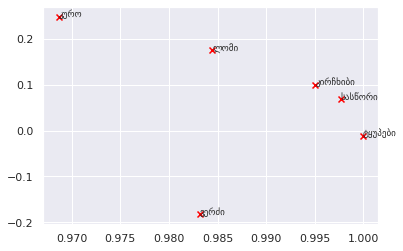

In [39]:
words = ["ვერძი", "კურო", "ტყუპები", "კირჩხიბი", "ლომი", "სასწორი"]
plot_embeddings(M_reduced_normalized, word2ind, words)

In [1]:
words = ["მეფე", "კაცი", "დედოფალი", "ქალი"]
plot_embeddings(M_reduced_normalized, word2ind, words)

NameError: name 'plot_embeddings' is not defined

In [40]:
model.wv.most_similar(positive=['მეფე', 'ქალი'], negative=['კაცი'])

[('ელისაბედ', 0.5987329483032227),
 ('მეფედ', 0.5954987406730652),
 ('ii-ის', 0.5854814648628235),
 ('მახარებელი', 0.5820518732070923),
 ('პრინცი', 0.575889527797699),
 ('ფოტომ', 0.5711617469787598),
 ('ექსპრეზიდენტის', 0.5700393915176392),
 ('შარლ', 0.5691030025482178),
 ('ვაჟის', 0.5660168528556824),
 ('მოციქულის', 0.5644959807395935)]

## Prepare and split data

In [97]:
# TODO: add test and validation ds
# MAIN ENTRYPOINT FOR DATA
flat_data = list(flatten(data))
flat_data[:5]

['ეროვნული', 'სააგენტო', ':', '"', 'ახალციხეში']

## Transformer model

In [98]:
import torch
from torch import nn
import math
from torchtext.vocab import build_vocab_from_iterator
from dataclasses import dataclass
from torch.nn.functional import log_softmax
import time
from torch import optim
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [99]:
@dataclass
class TransformerConfig:
    batch_size: int
    training_sequence_length: int
    embedding_size: int
    num_heads: int
    num_hidden_ff: int
    num_layers: int
    lr: float
    log_interval: int
    use_pretrained_embeddings: bool

In [100]:
# TRANSFORMER RELATED CONFIGURATION
config = TransformerConfig(
    batch_size=20, # we can afford this
    training_sequence_length=35,
    embedding_size=100,
    num_heads = 2,
    num_hidden_ff=100,
    num_layers = 2,
    lr = 0.2,
    log_interval = 1,
    use_pretrained_embeddings=True
)

In [101]:
# it's a good practice to fix working device before proceeding with the rest of the work...

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cuda')

In [102]:
train_vocab = build_vocab_from_iterator(
    iterator=[flat_data], # Vocabulary is built using training data, NOT valid/test sets.
    min_freq=1, # Omit tokens which occur less than min_freq times in the entire training data.
    specials=["<pad>", "<unk>"],
)

In [103]:
# To pad we just add zeroes
assert train_vocab['<pad>'] == 0 

In [104]:
# All unkown words will result into this token
train_vocab.set_default_index(train_vocab["<unk>"])

In [105]:
# make sure this looks sensible
train_vocab(['მე', 'მქვია', 'სანდრო'])

[37, 10791, 2700]

In [106]:
# [a, b, c, d, e, f]
# for batch_size=2 gets trasformed into
# [ a d ] |
# [ b e ] |
# [ c f ] V
# This allows to get a batch with just res[start:end] and you get sequences
# from different parts of data
def align_for_batching(data: torch.Tensor, batch_size: int):
    col_size = data.shape[0] // batch_size
    data = data.narrow(0, 0, col_size * batch_size)
    data = data.view(batch_size, -1).t().contiguous()
    return data.to(DEVICE)

In [107]:
# MAIN DATA CONERTED TO TENSOR
train_ids = torch.tensor(train_vocab(flat_data))

In [108]:
# each slice on 0 dimension is now a batch
train_batched = align_for_batching(train_ids, config.batch_size)

In [109]:
assert train_batched.shape[1] == config.batch_size

#### Abbreviations used below:
Model takes in input of dimensions (S, N, E)

S - Sequence length

N - Batch size

E=d_model=ninp - Embedding size same as d_model from paper or 

ntoken - vocab size

nhead - Number of heads in each multi-head attention

nhid - Size of hidden vector in a feed-forward model following each layer of multi-attention

nlayers - number of attention layers

In [110]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [111]:
# test/example dims
S, N, E = (2, 3, 10)
sample = torch.zeros((S, N, E))
assert PositionalEncoding(E)(sample).shape == sample.shape

In [112]:
class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5, pretrained_vectors=None):
        super(TransformerModel, self).__init__()
        
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        if pretrained_vectors == None:
            self.encoder = nn.Embedding(ntoken, ninp)
        else:
            assert pretrained_vectors.shape == (ntoken, ninp), pretrained_vectors.shape
            self.encoder = nn.Embedding.from_pretrained(pretrained_vectors, freeze=True)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    # This is used to prevent words from using context from following words(cheating)
    # def _generate_square_subsequent_mask(self, sz):
    #     mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    #     mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    #     return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=True):
        # if has_mask:
        #     device = src.device
        #     if self.src_mask is None or self.src_mask.size(0) != len(src):
        #         mask = self._generate_square_subsequent_mask(len(src)).to(device)
        #         self.src_mask = mask
        # else:
        #     self.src_mask = None

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        # output = self.transformer_encoder(src, self.src_mask)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        return log_softmax(output, dim=-1)

In [113]:
# test/example dims
V, E, nhead, nhid, nlayers = (15, 10, 5, 11, 4)
S1, N = (12, 3)
S2, N = (13, 3)
sample12 = torch.zeros((S1, N), dtype=torch.int)
sample13 = torch.zeros((S2, N), dtype=torch.int)
model = TransformerModel(V, E, nhead, nhid, nlayers)
# (S, N, V) each transformer goes through FF layer and then softmax to give us probabilities of token at that index
assert model(sample12).shape == (S1, N, V)
assert model(sample13).shape == (S2, N, V)

In [114]:
from gensim.models import Word2Vec

In [115]:
# Load pre-trained embeddings
# RERUN THIS IF YOU WANT TO FULLY RESET MODEL(it changes if freeze=False)
if config.use_pretrained_embeddings:
    wv = Word2Vec.load('./models/word2vec/word2vec_10m.model').wv
    vecs = np.array([wv[s] if s in wv else np.zeros ((wv.vector_size,))  for s in train_vocab.get_itos() ])
    vectors = torch.FloatTensor(vecs)
    assert wv.vector_size == config.embedding_size
else:
    vectors = None

#### Train

In [116]:
model = TransformerModel(
    len(train_vocab), 
    config.embedding_size, 
    config.num_heads, 
    config.num_hidden_ff, 
    config.num_layers, 
    pretrained_vectors=vectors)

In [117]:
model = model.to(DEVICE)
torch.manual_seed(78)

RuntimeError: CUDA out of memory. Tried to allocate 370.00 MiB (GPU 0; 11.17 GiB total capacity; 145.37 MiB already allocated; 245.81 MiB free; 166.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [62]:
# TODO: Is this good?
loss_fn = nn.NLLLoss()

In [63]:
config.lr = 0.001
# TODO: Is this good?
optimizer = optim.Adam(model.parameters(), lr=config.lr)

In [64]:
losses = []
def train_epoch(model, train_batched, config):
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(train_vocab)
    for batch_id, batch_start in enumerate(range(0, train_batched.shape[0], config.training_sequence_length)):
        # TODO: REFACTOR THIS
        # (S, N, E)
        data = train_batched[batch_start:batch_start+config.training_sequence_length]
        targets = train_batched[batch_start+1:batch_start+config.training_sequence_length+1]
        # this only happens for the last batch
        if data.shape != targets.shape:
            data = data[:targets.shape[0]]
        assert data.shape == targets.shape
        
        # Reset gradients
        model.zero_grad()
        # Run model
        output = model(data)
        # Training step:
        # Flatten so it's easy to compare
        # (N*S)
        targets = targets.view(-1)
        # (N*S, V)
        output = output.view(-1, ntokens)
        assert output.shape[1] == ntokens, output.shape
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        
        # print(loss)
        losses.append(loss)

        # Debug/Log:
        total_loss += loss
        if (batch_id + 1) % config.log_interval == 0 and batch_id > 0:
            elapsed = time.time() - start_time
            cur_loss = total_loss / config.log_interval
            total_loss=0
            
            print(f'{batch_id = } | {cur_loss =} | elapsed time {elapsed}')
            samples = ['ჩემი აზრით', 'დღეს გარეთ ძალიან წვიმს. არ დაგავიწყდეს']
            for sample in samples:
                res = gen_sentence_until_dot(sample)
                print(f"eval({sample}) = {res}")
            model.train()

In [65]:
config.log_interval = 10

In [66]:
for epochs in range(0, 1):
    train_epoch(model, train_batched, config)

In [81]:
model

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=100, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=100, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        

In [68]:
def evaluate_single_sentence(s: str):
    # Turn on evaluation mode which disables dropout.
    token_ids = train_vocab(tokenizer(s))
    model.eval()
    ntokens = len(train_vocab)
    with torch.no_grad():
        data = torch.IntTensor(token_ids).to(DEVICE)
        data = data.view(-1, 1) # (S, N)
        output = model.to(data.device)(data, has_mask=False) # (S, 1, V)
        output = output[-1].view(-1) # (V,)
        assert output.shape == (ntokens,), output.shape
    return output

In [69]:
def get_best_next_token(s: str, algo='greedy'):
    out = evaluate_single_sentence(s)
    if algo == 'greedy':
        return train_vocab.get_itos()[out.argmax()]
    elif algo == 'top_k_top_p':
        out = top_k_top_p(out, top_k, top_p)
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, 1)
        return train_vocab.get_itos()[next_token]

In [70]:
def gen_sentence_until_dot(s: str, max_tok: int = 10, algo='top_k_top_p'):
    for _ in range(max_tok):
        next_tok = get_best_next_token(s, algo)
        s+=' '
        s+=next_tok
        #if next_tok in ['.', '?', '!']:
         #   break
    return s

In [71]:
s = 'სალამი მეგობრებო'

In [72]:
logits = evaluate_single_sentence(s)
logits

tensor([-15.6542, -15.8704,  -4.1132,  ..., -14.0999, -14.0715, -14.1694],
       device='cuda:0')

In [73]:
top_k = 5
top_p = 0.9
temperature = 1.0

In [74]:
def top_k_top_p(logits, top_k=0, top_p=0.0):
    top_k = min(top_k, logits.size(-1)) # make sure top_k is smaller than logit size
    if top_k > 0:
        # keep only top_k entries
        rm_id = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[rm_id] = -float('inf')
        
    if top_p > 0:
        # keep entries that sum up to top_p percentage
        sorted_logits, sorted_ids = torch.sort(logits, descending=True)
        cum_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
        
        sorted_rm_id = cum_probs > top_p
        sorted_rm_id[..., 1:] = sorted_rm_id[..., :-1].clone()
        sorted_rm_id[..., 0] = 0
        
        rm_id = sorted_ids[sorted_rm_id]
        logits[rm_id] = -float('inf')
        
    return logits

In [85]:
gen_sentence_until_dot(s)

'სალამი მეგობრებო ? - არ - ? - , - - -'

In [110]:
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, ntoken):
        super(LSTMModel, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = ntoken
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            bidirectional=False,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [123]:
model = LSTMModel(
    len(train_vocab)
)

model = model.to(DEVICE)
torch.manual_seed(78)

# TODO: Is this good?
loss_fn = nn.NLLLoss()

config.lr = 0.001
# TODO: Is this good?
optimizer = optim.Adam(model.parameters(), lr=config.lr)

In [ ]:
def evaluate_single_sentence(s: str):
    # Turn on evaluation mode which disables dropout.
    token_ids = train_vocab(tokenizer(s))
    model.eval()
    ntokens = len(train_vocab)
    
    state_h, state_c = model.init_state(1)
    state_h = state_h.to(DEVICE)
    state_c = state_c.to(DEVICE)
    
    with torch.no_grad():
        data = torch.IntTensor(token_ids).to(DEVICE)
        data = data.view(-1, 1) # (S, N)
        output, (state_h, state_c) = model.to(data.device)(data, (state_h, state_c)) # (S, 1, V)
        output = output[-1].view(-1) # (V,)
        assert output.shape == (ntokens,), output.shape
    return output

In [150]:
losses = []
def train_epoch(model, train_batched, config):
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = len(train_vocab)
    
    state_h, state_c = model.init_state(config.batch_size)
    state_h = state_h.to(DEVICE)
    state_c = state_c.to(DEVICE)
    
    for batch_id, batch_start in enumerate(range(0, train_batched.shape[0], config.training_sequence_length)):
        # TODO: REFACTOR THIS
        # (S, N, E)
        data = train_batched[batch_start:batch_start+config.training_sequence_length]
        targets = train_batched[batch_start+1:batch_start+config.training_sequence_length+1]
        # this only happens for the last batch
        if data.shape != targets.shape:
            data = data[:targets.shape[0]]
        assert data.shape == targets.shape
        
        # Reset gradients
        model.zero_grad()
        # Run model
        output, (state_h, state_c) = model(data, (state_h, state_c))
        # Training step:
        # Flatten so it's easy to compare
        # (N*S)
        targets = targets.view(-1)
        # (N*S, V)
        output = output.view(-1, ntokens)
        assert output.shape[1] == ntokens, output.shape
        loss = loss_fn(output, targets)
        
        state_h = state_h.detach()
        state_c = state_c.detach()
            
        loss.backward()
        optimizer.step()
        
        # print(loss)
        losses.append(loss)

        # Debug/Log:
        total_loss += loss
        if (batch_id + 1) % config.log_interval == 0 and batch_id > 0:
            elapsed = time.time() - start_time
            cur_loss = total_loss / config.log_interval
            total_loss=0
            
            print(f'{batch_id = } | {cur_loss =} | elapsed time {elapsed}')
            samples = ['ჩემი აზრით', 'დღეს გარეთ ძალიან წვიმს. არ დაგავიწყდეს']
            for sample in samples:
                res = gen_sentence_until_dot(sample)
                print(f"eval({sample}) = {res}")
            model.train()

In [151]:
for epochs in range(0, 1):
    train_epoch(model, train_batched, config)

batch_id = 9 | cur_loss =tensor(-6.2712, device='cuda:0', grad_fn=<DivBackward0>) | elapsed time 1.2504632472991943
eval(ჩემი აზრით) = ჩემი აზრით - ? - - - - , ? - ,
eval(დღეს გარეთ ძალიან წვიმს. არ დაგავიწყდეს) = დღეს გარეთ ძალიან წვიმს. არ დაგავიწყდეს - - - - - - - არ - -
batch_id = 19 | cur_loss =tensor(-5.0307, device='cuda:0', grad_fn=<DivBackward0>) | elapsed time 3.8330440521240234
eval(ჩემი აზრით) = ჩემი აზრით , - - - - - - - - -
eval(დღეს გარეთ ძალიან წვიმს. არ დაგავიწყდეს) = დღეს გარეთ ძალიან წვიმს. არ დაგავიწყდეს არ - - ? - ? ? - - -
batch_id = 29 | cur_loss =tensor(-5.5531, device='cuda:0', grad_fn=<DivBackward0>) | elapsed time 6.413437366485596
eval(ჩემი აზრით) = ჩემი აზრით - - არ - არ - - - - -
eval(დღეს გარეთ ძალიან წვიმს. არ დაგავიწყდეს) = დღეს გარეთ ძალიან წვიმს. არ დაგავიწყდეს - - - - არ , - ? , არ
batch_id = 39 | cur_loss =tensor(-6.2552, device='cuda:0', grad_fn=<DivBackward0>) | elapsed time 8.978631734848022
eval(ჩემი აზრით) = ჩემი აზრით - - , - - - - - - -
eval(

KeyboardInterrupt: 